## Introduction
-----

In this assignment you will recursively estimate the position of a vehicle along a trajectory using available measurements and a motion model. 

The vehicle is equipped with a very simple type of LIDAR sensor, which returns range and bearing measurements corresponding to individual landmarks in the environment. The global positions of the landmarks are assumed to be known beforehand. We will also assume known data association, that is, which measurment belong to which landmark.

## Motion and Measurement Models
-----

### Motion Model

The vehicle motion model recieves linear and angular velocity odometry readings as inputs, and outputs the state (i.e., the 2D pose) of the vehicle:

\begin{align}
\mathbf{x}_{k} &= \mathbf{x}_{k-1} + T
\begin{bmatrix}
\cos\theta_{k-1} &0 \\
\sin\theta_{k-1} &0 \\
0 &1
\end{bmatrix}
\left(
\begin{bmatrix}
v_k \\
\omega_k
\end{bmatrix}
+ \mathbf{w}_k
\right)
\, , \, \, \, \, \, \mathbf{w}_k = \mathcal{N}\left(\mathbf{0}, \mathbf{Q}\right)
\end{align}

- $\mathbf{x}_k = \left[ x \, y \, \theta \right]^T$ is the current 2D pose of the vehicle
- $v_k$ and $\omega_k$ are the linear and angular velocity odometry readings, which we use as inputs to the model

The process noise $\mathbf{w}_k$ has a (zero mean) normal distribution with a constant covariance $\mathbf{Q}$.

### Measurement Model

The measurement model relates the current pose of the vehicle to the LIDAR range and bearing measurements $\mathbf{y}^l_k = \left[r \, \phi \right]^T$.

\begin{align}
\mathbf{y}^l_k =
\begin{bmatrix}
\sqrt{(x_l - x_k - d\cos\theta_{k})^2 + (y_l - y_k - d\sin\theta_{k})^2} \\
atan2\left(y_l - y_k - d\sin\theta_{k},x_l - x_k - d\cos\theta_{k}\right) - \theta_k
\end{bmatrix}
+
\mathbf{n}^l_k
\, , \, \, \, \, \, \mathbf{n}^l_k = \mathcal{N}\left(\mathbf{0}, \mathbf{R}\right)
\end{align}

- $x_l$ and $y_l$ are the ground truth coordinates of the landmark $l$
- $x_k$ and $y_k$ and $\theta_{k}$ represent the current pose of the vehicle
- $d$ is the known distance between robot center and laser rangefinder (LIDAR)

The landmark measurement noise $\mathbf{n}^l_k$ has a (zero mean) normal distribution with a constant covariance $\mathbf{R}$.

## Getting Started
-----

Since the models above are nonlinear, we recommend using the extended Kalman filter (EKF) as the state estimator.
Specifically, you will need to provide code implementing the following steps:
- the prediction step, which uses odometry measurements and the motion model to produce a state and covariance estimate at a given timestep, and
- the correction step, which uses the range and bearing measurements provided by the LIDAR to correct the pose and pose covariance estimates

### Unpack the Data
First, let's unpack the available data:

In [55]:
import pickle
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

with open('data/data.pickle', 'rb') as f:
    data = pickle.load(f)

t = data['t']  # timestamps [s]

x_init  = data['x_init'] # initial x position [m]
y_init  = data['y_init'] # initial y position [m]
th_init = data['th_init'] # initial theta position [rad]

# input signal
v  = data['v']  # translational velocity input [m/s]
om = data['om']  # rotational velocity input [rad/s]

# bearing and range measurements, LIDAR constants
b = data['b']  # bearing to each landmarks center in the frame attached to the laser [rad]
r = data['r']  # range measurements [m]
l = data['l']  # x,y positions of landmarks [m]
d = data['d']  # distance between robot center and laser rangefinder [m]


Note that distance from the LIDAR frame to the robot center is provided and loaded as an array into the `d` variable.

### Ground Truth
If available, it is useful to plot the ground truth position and orientation before starting the assignment.

<table><tr>
<td> <img src="data/gtruth.png" alt="Ground Truth" width="350"/> </td>
<td> <img src="data/gtruth2.png" alt="Ground Truth" width="350"/> </td>
</tr></table>

Notice that the orientation values are wrapped to the $\left[-\pi,\pi\right]$ range in radians.

### Initializing Parameters

Now that our data is loaded, we can begin getting things set up for our solver. One of the
most important aspects of designing a filter is determining the input and measurement noise covariance matrices, as well as the initial state and covariance values. We set the values here:

In [56]:
v_var = 0.01  # translation velocity variance  
om_var = 0.01  # rotational velocity variance 
r_var = 0.001  # range measurements variance
b_var = 0.001  # bearing measurement variance

Q_km = np.diag([v_var, om_var]) # input noise covariance 
cov_y = np.diag([r_var, b_var])  # measurement noise covariance 

x_est = np.zeros([len(v), 3])  # estimated states, x, y, and theta
P_est = np.zeros([len(v), 3, 3])  # state covariance matrices

x_est[0] = np.array([x_init, y_init, th_init]) # initial state
P_est[0] = np.diag([1, 1, 0.1]) # initial state covariance

**Remember:** that it is neccessary to tune the measurement noise variances `r_var`, `b_var` in order for the filter to perform well!

In order for the orientation estimates to coincide with the bearing measurements, it is also neccessary to wrap all estimated $\theta$ values to the $(-\pi , \pi]$ range.

In [57]:
# Wraps angle to (-pi,pi] range
def wraptopi(x):
    if x > np.pi:
        x = x - (np.floor(x / (2 * np.pi)) + 1) * 2 * np.pi
    elif x < -np.pi:
        x = x + (np.floor(x / (-2 * np.pi)) + 1) * 2 * np.pi
    return x


## Correction Step
-----
First, let's implement the measurement update function, which takes an available landmark measurement $l$ and updates the current state estimate $\mathbf{\check{x}}_k$.
For each landmark measurement received at a given timestep $k$, you should implement the following steps:

- Compute the measurement model Jacobians at $\mathbf{\check{x}}_{k}$
\begin{align}
\mathbf{y}^l_k = &\mathbf{h}(\mathbf{x}_{k}, \mathbf{n}^l_k) \\\\
\mathbf{H}_{k} = \frac{\partial \mathbf{h}}{\partial \mathbf{x}_{k}}\bigg|_{\mathbf{\check{x}}_{k},0}& \, , \, \, \, \,
\mathbf{M}_{k} = \frac{\partial \mathbf{h}}{\partial \mathbf{n}_{k}}\bigg|_{\mathbf{\check{x}}_{k},0} \, .
\end{align}
- Compute the Kalman Gain
\begin{align}
\mathbf{K}_k &= \mathbf{\check{P}}_k \mathbf{H}_k^T \left(\mathbf{H}_k \mathbf{\check{P}}_k \mathbf{H}_k^T + \mathbf{M}_k \mathbf{R}_k \mathbf{M}_k^T \right)^{-1} 
\end{align}
- Correct the predicted state
\begin{align}
\mathbf{\check{y}}^l_k &= \mathbf{h}\left(\mathbf{\check{x}}_k, \mathbf{0}\right) \\
\mathbf{\hat{x}}_k &= \mathbf{\check{x}}_k + \mathbf{K}_k \left(\mathbf{y}^l_k - \mathbf{\check{y}}^l_k\right)
\end{align}
- Correct the covariance
\begin{align}
\mathbf{\hat{P}}_k &= \left(\mathbf{I} - \mathbf{K}_k \mathbf{H}_k \right)\mathbf{\check{P}}_k
\end{align}

In [58]:
def measurement_update(lk, rk, bk, P_check, x_check):
    
    # 1. Compute measurement Jacobian
    xl = lk[0]
    yl = lk[1]
    xk = x_check[0]
    yk = x_check[1]
    thetak = wraptopi(x_check[2])
    equX = xl-xk-d[0]*np.cos(thetak)
    equY = yl-yk-d[0]*np.sin(thetak)
    equXY = equX**2+equY**2 
    print(xl,yl,'\n',xk,yk,'\n',thetak,'\n',equX,equY,equXY)
    
    H11 = -equX/( equXY )**0.5
    H21 = -2*(equX)**3*(equY)**2/equXY**3
    H12 = -equY/(equXY)**0.5
    H22 = -2*equX**4*equY/equXY**3
    H13 = (equX*d[0]*np.sin(thetak)-equY*d[0]*np.cos(thetak))/(equXY)**0.5
    H23 = equX**2*( equXY*2*equX*d[0]*np.sin(thetak) - equX**2*(2*equX*d[0]*np.sin(thetak)-2*equY*d[0]*np.cos(thetak)) )/(equXY**3)-1
    
    H_k = np.array([[H11, H12, H13], [H21, H22, H23]])
    
    M_k = np.diag([1.0, 1.0])
    
    R = cov_y
    print('H_k: ', H13)

    # 2. Compute Kalman Gain
    
    ppp=(inv((H_k@P_check)@H_k.T + (M_k@R)@M_k.T))
    K_k = P_check.dot(H_k.T)@ppp
    print('K_k: ',K_k)
    print('P_check: ',P_check)

    # 3. Correct predicted state (remember to wrap the angles to [-pi,pi])
    y11 = equXY**0.5
    y12 = wraptopi(np.arctan2(equY, equX)-thetak)
    y_check = np.array([y11, y12]).T
    y_meas = np.array([rk, bk])
    x_hat = x_check+K_k.dot(y_meas-y_check)
    x_hat[2] = wraptopi(x_hat[2])

    # 4. Correct covariance
    P_hat = (np.diag([1, 1, 1])-K_k@H_k)@P_check
    
    x_check = x_hat
    P_check = P_hat

    return x_check, P_check


## Prediction Step
-----
Now, implement the main filter loop, defining the prediction step of the EKF using the motion model provided:

\begin{align}
\mathbf{\check{x}}_k &= \mathbf{f}\left(\mathbf{\hat{x}}_{k-1}, \mathbf{u}_{k-1}, \mathbf{0} \right) \\
\mathbf{\check{P}}_k &= \mathbf{F}_{k-1}\mathbf{\hat{P}}_{k-1}\mathbf{F}_{k-1}^T + \mathbf{L}_{k-1}\mathbf{Q}_{k-1}\mathbf{L}_{k-1}^T \, .
\end{align}

Where

\begin{align}
\mathbf{F}_{k-1} = \frac{\partial \mathbf{f}}{\partial \mathbf{x}_{k-1}}\bigg|_{\mathbf{\hat{x}}_{k-1},\mathbf{u}_{k},0}  \, , \, \, \, \,
\mathbf{L}_{k-1} = \frac{\partial \mathbf{f}}{\partial \mathbf{w}_{k}}\bigg|_{\mathbf{\hat{x}}_{k-1},\mathbf{u}_{k},0} \, .
\end{align}

In [59]:
#### 5. Main Filter Loop #######################################################################
for k in range(1, len(t)):  # start at 1 because we've set the initial prediciton

    delta_t = t[k] - t[k - 1]  # time step (difference between timestamps)

    # 1. Update state with odometry readings (remember to wrap the angles to [-pi,pi])
    x_check = np.zeros(3)
    x_check = x_est[k-1]
    P_check = P_est[k-1]

    # 2. Motion model jacobian with respect to last state
    F_km = np.zeros([3, 3])
    F_km[1,1] = 1.0
    F_km[2,2] = 1.0
    F_km[0,0] = 1.0
    F_km[0,2] = -v[k]*np.sin(x_check[2])*delta_t-om[k]*np.sin(x_check[2])*delta_t
    F_km[1,2] = v[k]*np.cos(x_check[2])*delta_t+om[k]*np.cos(x_check[2])*delta_t

    # 3. Motion model jacobian with respect to noise
    L_km = np.zeros([3, 2])
    L_km[0,0] = np.cos(x_check[2])*delta_t
    L_km[1,0] = np.sin(x_check[2])*delta_t
    L_km[2,1] = delta_t

    # 4. Propagate uncertainty
    theta = x_check[2]
    B_mat = np.array([[np.cos(theta), 0], [np.sin(theta), 0], [0, 1]])
    u_input = np.array([v[k], om[k] ]).T
    x_check = x_check+delta_t*(B_mat@u_input)
    P_check = F_km@P_check@F_km.T + L_km@Q_km@L_km.T

    # 5. Update state estimate using available landmark measurements
    for i in range(len(r[k])):
        x_check, P_check = measurement_update(l[i], r[k, i], b[k, i], P_check, x_check)

    # Set final state predictions for timestep
    x_est[k, 0] = x_check[0]
    x_est[k, 1] = x_check[1]
    x_est[k, 2] = x_check[2]
    P_est[k, :, :] = P_check

20 0 
 50.0 0.6964825212898175 
 1.6381619898228383 
 -30.0 -0.6964825212898175 900.4850879024622
H_k:  -0.0
K_k:  [[ 9.98760000e-01  7.12988951e-04]
 [ 2.22187052e-02 -1.24019450e-03]
 [-6.13849056e-04 -9.90522522e-01]]
P_check:  [[ 1.05834640e+00 -2.96036350e-18 -7.63848184e-02]
 [-2.96036350e-18  1.01000000e+00  4.67722117e-18]
 [-7.63848184e-02  4.67722117e-18  1.10000000e-01]]
-20 0 
 49.97998361513869 0.6960114947350429 
 1.6178787661540817 
 -69.97998361513869 -0.6960114947350429 4897.682538775884
H_k:  -0.0
K_k:  [[ 6.01624448e-01  9.86241504e-03]
 [-6.13932268e+00 -5.85266258e-01]
 [-5.78411314e-03 -4.98154748e-01]]
P_check:  [[ 1.54260989e-03 -2.34139730e-02 -3.68378330e-05]
 [-2.34139730e-02  1.00948109e+00  1.56028978e-03]
 [-3.68378330e-05  1.56028978e-03  9.92932221e-04]]
40 10 
 49.980494212810655 0.6900708597100528 
 1.6171234114558204 
 -9.980494212810655 9.309929140289947 186.28504532916688
H_k:  0.0
K_k:  [[ 2.46526740e-02 -7.81376913e-04]
 [-1.43451791e+00 -4.289985

 [-0.00353598 -0.24432325]]
P_check:  [[ 1.18130393e-04 -2.43306309e-04  2.07259776e-06]
 [-2.43306309e-04  3.16971245e-03 -4.32211485e-05]
 [ 2.07259776e-06 -4.32211485e-05  3.23256452e-04]]
0 20 
 49.60476082506779 6.279791808605746 
 1.666281026012742 
 -49.60476082506779 13.720208191394253 2648.876409327382
H_k:  0.0
K_k:  [[ 0.12318069  0.00073699]
 [-0.73570262  0.00095009]
 [ 0.00642412 -0.19611918]]
P_check:  [[ 1.13446577e-04 -2.64254412e-04  1.62372378e-06]
 [-2.64254412e-04  3.07256106e-03 -2.86910146e-05]
 [ 1.62372378e-06 -2.86910146e-05  2.44218713e-04]]
0 -20 
 49.602057097264186 6.295946769669646 
 1.6658902073159891 
 -49.602057097264186 -26.295946769669648 3151.840884793556
H_k:  -0.0
K_k:  [[ 0.012902   -0.00147717]
 [ 0.6508143   0.02638677]
 [-0.0043673  -0.16411987]]
P_check:  [[ 9.12995973e-05 -1.31985958e-04  6.68598609e-07]
 [-1.31985958e-04  2.28257825e-03 -2.16808683e-05]
 [ 6.68598609e-07 -2.16808683e-05  1.96314639e-04]]
60 -30 
 49.60111189074427 6.2483463

K_k:  [[ 0.17219831  0.03202654]
 [-0.2868302  -0.10564916]
 [-0.00592677 -0.24595286]]
P_check:  [[ 7.69176666e-04 -2.23054219e-03 -5.34169970e-05]
 [-2.23054219e-03  7.41335341e-03  1.74893720e-04]
 [-5.34169970e-05  1.74893720e-04  3.26801241e-04]]
0 20 
 48.23468301555171 12.627326177238983 
 1.8413996814364832 
 -48.23468301555171 7.372673822761017 2380.940964907578
H_k:  0.0
K_k:  [[ 0.41569684  0.01675703]
 [-1.28089538 -0.0625319 ]
 [-0.01806256 -0.19697684]]
P_check:  [[ 7.34956166e-04 -2.17125823e-03 -4.15516379e-05]
 [-2.17125823e-03  7.30717585e-03  1.38077559e-04]
 [-4.15516379e-05  1.38077559e-04  2.46564992e-04]]
0 -20 
 48.25814617485311 12.555029812752071 
 1.8404010627189573 
 -48.25814617485311 -32.55502981275207 3388.6786383426656
H_k:  -0.0
K_k:  [[-0.14859507  0.00430566]
 [ 0.75378125 -0.01275975]
 [ 0.0094972  -0.16412289]]
P_check:  [[ 2.95645935e-04 -8.17002410e-04 -1.16584275e-05]
 [-8.17002410e-04  3.13228191e-03  4.32705792e-05]
 [-1.16584275e-05  4.3270579

 -6.725929978708265 -6.635417101440396 89.26689418857424
H_k:  -0.0
K_k:  [[-0.47141453 -0.00726718]
 [ 1.17196971  0.02481868]
 [ 0.01473263 -0.32235312]]
P_check:  [[ 1.21141649e-03 -2.53857678e-03 -2.38934206e-05]
 [-2.53857678e-03  5.83187712e-03  4.89461897e-05]
 [-2.38934206e-05  4.89461897e-05  4.76822717e-04]]
-40 -10 
 46.745383603575924 16.587100618642026 
 2.0039349766034906 
 -86.74538360357593 -26.587100618642026 8231.635495837336
H_k:  -0.0
K_k:  [[ 0.27127014  0.00859221]
 [-0.40626024 -0.0181552 ]
 [-0.00463897 -0.24414122]]
P_check:  [[ 7.77299122e-04 -1.45914544e-03 -1.91651075e-05]
 [-1.45914544e-03  3.14780750e-03  4.04042090e-05]
 [-1.91651075e-05  4.04042090e-05  3.23173877e-04]]
0 20 
 46.73070413817606 16.609069045407736 
 2.0034536752488084 
 -46.73070413817606 3.390930954592264 2195.257121988557
H_k:  0.0
K_k:  [[ 0.41460488  0.00789007]
 [-0.81279414 -0.01890467]
 [-0.00666085 -0.19625627]]
P_check:  [[ 6.91581830e-04 -1.33070681e-03 -1.46311017e-05]
 [-1.330

40 10 
 43.854439990990926 21.106041030826322 
 2.3207616319242765 
 -3.854439990990926 -11.106041030826322 138.20085502254793
H_k:  -0.0
K_k:  [[-0.61495333  0.00581851]
 [ 0.81235941 -0.00486434]
 [ 0.00090547 -0.32269363]]
P_check:  [[ 1.76892008e-03 -2.11326526e-03 -8.67024444e-06]
 [-2.11326526e-03  2.71405098e-03  8.33875742e-06]
 [-8.67024444e-06  8.33875742e-06  4.76441355e-04]]
-40 -10 
 43.84309525663745 21.12103997669184 
 2.3193558413264186 
 -83.84309525663744 -31.12103997669184 7998.183751444431
H_k:  -0.0
K_k:  [[ 0.38810975 -0.00078838]
 [-0.37291526  0.00238749]
 [-0.00146746 -0.24395424]]
P_check:  [[ 8.97776814e-04 -9.62516535e-04 -2.80155385e-06]
 [-9.62516535e-04  1.19394182e-03  1.93075186e-06]
 [-2.80155385e-06  1.93075186e-06  3.22682228e-04]]
0 20 
 43.84259807996418 21.12151731433527 
 2.3194137831985393 
 -43.84259807996418 -1.1215173143352715 1923.431207487633
H_k:  -0.0
K_k:  [[ 4.09864933e-01  6.79414953e-04]
 [-4.49766831e-01 -1.51433220e-04]
 [-1.1869253

 [ 1.61234502e-07 -2.35784283e-07  1.63961582e-04]]
-60 30 
 40.84447674999402 23.56622626360807 
 2.5697758767703633 
 -100.84447674999402 6.433773736391931 10211.00193547117
H_k:  0.0
K_k:  [[ 2.41866762e-01  1.52470836e-04]
 [-1.40013816e-01 -9.41314221e-05]
 [ 3.61462017e-05 -1.23472022e-01]]
P_check:  [[ 3.12091070e-04 -1.75220930e-04  1.17499725e-08]
 [-1.75220930e-04  1.86778159e-04 -1.06351650e-07]
 [ 1.17499725e-08 -1.06351650e-07  1.40865047e-04]]
20 0 
 40.607461529946455 23.71916556835071 
 2.607045648962048 
 -20.607461529946455 -23.71916556835071 987.266285967057
H_k:  -0.0
K_k:  [[ 9.88354560e-01  8.14533676e-04]
 [-5.67889814e-01  3.62268695e-03]
 [ 1.79600749e-03 -9.10055591e-01]]
P_check:  [[ 7.31096882e-03 -4.67400939e-03 -2.18548931e-05]
 [-4.67400939e-03  3.09702754e-03 -3.41354512e-05]
 [-2.18548931e-05 -3.41354512e-05  1.01234722e-02]]
-20 0 
 40.620087612036016 23.711758857177134 
 2.640884755002035 
 -60.620087612036016 -23.711758857177134 4237.04253019184
H_k:

 [ 3.16857367e-05 -1.23426701e-05  9.10273383e-04]]
40 10 
 36.805377328379954 24.988252596297134 
 3.0283075417654293 
 3.1946226716200457 -14.988252596297134 234.85332990443658
H_k:  0.0
K_k:  [[-0.40698879 -0.00347815]
 [ 0.17449898  0.00202922]
 [-0.0022074  -0.32269941]]
P_check:  [[ 1.13030797e-03 -3.18055813e-04  5.96767309e-06]
 [-3.18055813e-04  1.71874556e-04 -3.53274529e-06]
 [ 5.96767309e-06 -3.53274529e-06  4.76463648e-04]]
-40 -10 
 36.85388888724634 24.967450406436118 
 3.030104312549572 
 -76.85388888724634 -34.967450406436114 7129.242825019775
H_k:  -0.0
K_k:  [[ 0.45688322 -0.00077117]
 [-0.09237353  0.00145626]
 [ 0.00087655 -0.24396914]]
P_check:  [[ 9.07785129e-04 -2.22643822e-04  2.39793121e-06]
 [-2.22643822e-04  1.30963954e-04 -1.74588207e-06]
 [ 2.39793121e-06 -1.74588207e-06  3.22696282e-04]]
0 20 
 36.840980040734 24.970059818349636 
 3.0301777583868685 
 -36.840980040734 -4.970059818349636 1381.9593049597347
H_k:  -0.0
K_k:  [[ 0.3588135  -0.00111654]
 [-0.0

 [ 0.00456531 -0.47646745]]
P_check:  [[ 2.60696196e-03  1.21784892e-04  2.05307766e-05]
 [ 1.21784892e-04  1.06955298e-04 -3.74775049e-06]
 [ 2.05307766e-05 -3.74775049e-06  9.10213497e-04]]
40 10 
 33.26268301096828 24.898479594492 
 -2.993015362924355 
 6.737316989031719 -14.898479594491999 267.3561344381899
H_k:  -0.0
K_k:  [[-0.27173466 -0.00667773]
 [ 0.07237895  0.00114822]
 [-0.00163479 -0.32270645]]
P_check:  [[ 8.16287233e-04  6.30777827e-06  5.93539109e-06]
 [ 6.30777827e-06  9.94906509e-05 -1.91439407e-06]
 [ 5.93539109e-06 -1.91439407e-06  4.76475818e-04]]
-40 -10 
 33.280222286818656 24.893808764827348 
 -2.9924427335510964 
 -73.28022228681866 -34.89380876482735 6587.568868521896
H_k:  0.0
K_k:  [[ 4.09614917e-01  2.49752471e-04]
 [ 4.12422509e-02  1.32312887e-03]
 [ 8.69052802e-04 -2.43965152e-01]]
P_check:  [[ 7.26374203e-04  3.02495296e-05  1.61473225e-06]
 [ 3.02495296e-05  9.31149324e-05 -1.06397545e-06]
 [ 1.61473225e-06 -1.06397545e-06  3.22691558e-04]]
0 20 
 33.

K_k:  [[ 1.17305934 -0.00731354]
 [ 0.42231481  0.00414749]
 [ 0.00271751 -0.91010944]]
P_check:  [[ 9.13674574e-03  3.09050794e-03  2.34926541e-05]
 [ 3.09050794e-03  1.18786631e-03 -6.74811434e-05]
 [ 2.34926541e-05 -6.74811434e-05  1.01234731e-02]]
-20 0 
 28.85712936010881 23.593917459788045 
 -2.747917406402385 
 -48.857129360108814 -23.593917459788045 2943.692030409698
H_k:  0.0
K_k:  [[ 0.65563315 -0.00080253]
 [ 0.18796598  0.00353277]
 [ 0.00450499 -0.47645698]]
P_check:  [[ 1.97359363e-03  5.11639146e-04  1.38641862e-05]
 [ 5.11639146e-04  2.58913891e-04 -2.30579319e-06]
 [ 1.38641862e-05 -2.30579319e-06  9.10148754e-04]]
40 10 
 28.87027582806639 23.59767542362452 
 -2.7464282532427493 
 11.12972417193361 -13.59767542362452 308.7675370695655
H_k:  -0.0
K_k:  [[-0.25710339 -0.00845075]
 [ 0.02530376  0.00052587]
 [-0.00094811 -0.32269536]]
P_check:  [[ 6.62520885e-04  1.35756754e-04  5.60586428e-06]
 [ 1.35756754e-04  1.51121983e-04 -1.24882373e-06]
 [ 5.60586428e-06 -1.24882

 25.18205237147119 21.76243971864755 
 -2.6576214213734963 
 -85.18205237147119 8.23756028135245 7323.8394456049755
H_k:  0.0
K_k:  [[ 0.1630108  -0.00043208]
 [ 0.04041996 -0.00058287]
 [ 0.00031953 -0.12347392]]
P_check:  [[2.00420796e-04 6.03267381e-05 4.85173098e-07]
 [6.03267381e-05 1.24884237e-04 4.22605760e-07]
 [4.85173098e-07 4.22605760e-07 1.40866914e-04]]
20 0 
 24.663854775620973 21.489762756699893 
 -2.759351960893995 
 -4.6638547756209725 -21.489762756699893 483.5614447073283
H_k:  0.0
K_k:  [[ 1.08907020e+00 -6.83682037e-03]
 [ 5.93592762e-01  2.36567047e-03]
 [ 1.47380154e-04 -9.10101161e-01]]
P_check:  [[ 8.00827834e-03  4.16046463e-03  2.81727001e-05]
 [ 4.16046463e-03  2.31232133e-03 -5.25705580e-05]
 [ 2.81727001e-05 -5.25705580e-05  1.01234733e-02]]
-20 0 
 24.60850120230206 21.458586420976882 
 -2.609053345123222 
 -44.608501202302065 -21.458586420976882 2450.389310702318
H_k:  0.0
K_k:  [[ 0.61296234  0.00076155]
 [ 0.28031234  0.00374331]
 [ 0.00433449 -0.476447

 [ 5.53808409e-05 -7.60580241e-05  1.01234712e-02]]
-20 0 
 20.160455268226162 18.45249039754436 
 -2.509061482074501 
 -40.16045526822616 -18.45249039754436 1953.356569222661
H_k:  0.0
K_k:  [[ 6.09464131e-01  4.43649275e-04]
 [ 3.65867287e-01  5.69477632e-03]
 [ 5.53877768e-03 -4.76429203e-01]]
P_check:  [[ 1.81816802e-03  1.01777374e-03  1.19893023e-05]
 [ 1.01777374e-03  7.71596369e-04 -1.54014000e-06]
 [ 1.19893023e-05 -1.54014000e-06  9.10090108e-04]]
40 10 
 20.16115420925254 18.45293238773665 
 -2.5110218825238264 
 19.83884579074746 -8.452932387736649 465.03186826070544
H_k:  -0.0
K_k:  [[-0.30604101 -0.00226169]
 [-0.08541854  0.00411561]
 [-0.00252263 -0.32268185]]
P_check:  [[ 5.52275754e-04  2.57781720e-04  6.14521557e-06]
 [ 2.57781720e-04  3.15270709e-04 -1.08301970e-07]
 [ 6.14521557e-06 -1.08301970e-07  4.76464177e-04]]
-40 -10 
 20.15206647287569 18.450411391823636 
 -2.512148037981535 
 -60.15206647287569 -28.450411391823636 4427.697009321264
H_k:  0.0
K_k:  [[ 3.054

 -2.4440685965832403 
 -15.44609866390156 5.305050725117836 266.72552713105483
H_k:  0.0
K_k:  [[ 0.17578269 -0.00296876]
 [ 0.02025624 -0.00768899]
 [ 0.00158698 -0.19607891]]
P_check:  [[2.66813053e-04 1.32868858e-04 2.46229300e-06]
 [1.32868858e-04 3.12639709e-04 1.07811556e-06]
 [2.46229300e-06 1.07811556e-06 2.43960969e-04]]
0 -20 
 15.446742454154512 14.695005304240839 
 -2.444547318426092 
 -15.446742454154512 -34.69500530424084 1442.3452455062793
H_k:  0.0
K_k:  [[ 1.51387468e-01 -6.12542686e-04]
 [ 2.42026902e-01  1.10527370e-03]
 [ 5.72342225e-06 -1.63961853e-01]]
P_check:  [[ 2.30030843e-04  1.28602546e-04  1.39021240e-06]
 [ 1.28602546e-04  3.12077727e-04 -8.37833660e-07]
 [ 1.39021240e-06 -8.37833660e-07  1.96120776e-04]]
60 -30 
 15.44680742089629 14.695112949309342 
 -2.4448447217118896 
 44.55319257910371 -44.69511294930934 3982.6400905422215
H_k:  -0.0
K_k:  [[-0.07471353 -0.00154338]
 [ 0.09540441  0.00102617]
 [-0.00086652 -0.14087123]]
P_check:  [[ 1.98081025e-04  7

 -8.744062614867792 -28.60166571561563 894.5139127205512
H_k:  0.0
K_k:  [[ 0.1604953  -0.00101091]
 [ 0.27125194 -0.00063298]
 [ 0.00127288 -0.1639617 ]]
P_check:  [[2.35012649e-04 1.70093988e-04 1.89710359e-06]
 [1.70093988e-04 3.56901319e-04 1.60516516e-06]
 [1.89710359e-06 1.60516516e-06 1.96122913e-04]]
60 -30 
 8.74097132260039 8.596439154053366 
 -2.3695962258382517 
 51.25902867739961 -38.596439154053364 4117.173136323019
H_k:  -0.0
K_k:  [[-0.08395077 -0.00133115]
 [ 0.05847508  0.00025082]
 [-0.00028507 -0.14086578]]
P_check:  [[1.97877246e-04 1.07333284e-04 1.36346197e-06]
 [1.07333284e-04 2.50831176e-04 9.14198719e-07]
 [1.36346197e-06 9.14198719e-07 1.63964206e-04]]
-60 30 
 8.743613450542805 8.594600041127881 
 -2.3693300141332054 
 -68.74361345054281 21.405399958872117 5183.875537636933
H_k:  0.0
K_k:  [[ 0.1307625  -0.00120926]
 [ 0.03029124 -0.00212174]
 [ 0.00059534 -0.1234752 ]]
P_check:  [[1.90024477e-04 1.12801915e-04 1.09992522e-06]
 [1.12801915e-04 2.47022315e-04

H_k:  -0.0
K_k:  [[-8.76195232e-01  9.17654030e-05]
 [-8.46865932e-01  1.29093054e-02]
 [-6.13854336e-03 -9.10018910e-01]]
P_check:  [[ 5.19113553e-03  5.04381105e-03  7.13479145e-05]
 [ 5.04381105e-03  5.29110001e-03 -7.08367263e-05]
 [ 7.13479145e-05 -7.08367263e-05  1.01234705e-02]]
-20 0 
 1.2565802552687917 1.263913443927262 
 -2.3770618665313727 
 -21.25658025526879 -1.263913443927262 453.43968134242306
H_k:  0.0
K_k:  [[ 4.83976780e-01 -2.84893254e-04]
 [ 4.92895369e-01  6.16292033e-03]
 [ 2.80634560e-03 -4.76426228e-01]]
P_check:  [[ 9.38729675e-04  9.34250739e-04  5.87041923e-06]
 [ 9.34250739e-04  1.31775834e-03 -4.32677142e-06]
 [ 5.87041923e-06 -4.32677142e-06  9.09986766e-04]]
40 10 
 1.2519164370920346 1.2591025294009859 
 -2.372574045581184 
 38.748083562907965 8.740897470599014 1577.8172683896225
H_k:  0.0
K_k:  [[-0.32696969 -0.00349772]
 [-0.36860149 -0.00277605]
 [ 0.0004152  -0.32266333]]
P_check:  [[ 4.58369484e-04  4.45041121e-04  2.89931921e-06]
 [ 4.45041121e-04

K_k:  [[ 0.23193355  0.00262146]
 [ 0.23525134  0.01166957]
 [-0.00216816 -0.2441333 ]]
P_check:  [[ 2.81986481e-04  2.30990816e-04 -2.94991600e-06]
 [ 2.30990816e-04  5.54303952e-04 -1.22118423e-05]
 [-2.94991600e-06 -1.22118423e-05  3.22949020e-04]]
0 20 
 -3.7630615334114053 -3.7637022958820907 
 -2.3554944528841317 
 3.7630615334114053 23.76370229588209 578.8741789115523
H_k:  0.0
K_k:  [[-1.23020929e-01 -1.26530950e-05]
 [-3.26918887e-01  3.88187371e-03]
 [ 3.88635153e-03 -1.96162833e-01]]
P_check:  [[ 2.08427230e-04  1.56330800e-04 -9.48116810e-07]
 [ 1.56330800e-04  4.78419297e-04 -7.27044252e-06]
 [-9.48116810e-07 -7.27044252e-06  2.44068583e-04]]
0 -20 
 -3.760709634143269 -3.757458993398758 
 -2.3552334214819663 
 3.760709634143269 -16.242541006601243 277.9630753034609
H_k:  -0.0
K_k:  [[ 0.04017094 -0.00026584]
 [ 0.22588395  0.00253471]
 [-0.0025135  -0.1639861 ]]
P_check:  [[ 1.85421614e-04  9.51916707e-05 -4.95531988e-08]
 [ 9.51916707e-05  3.15918463e-04 -3.92692957e-06]

K_k:  [[-0.14350825  0.0004993 ]
 [-0.01306198  0.00389024]
 [-0.00043847 -0.14089123]]
P_check:  [[ 2.02421123e-04  9.84119912e-05 -2.06121521e-07]
 [ 9.84119912e-05  2.75942241e-04 -2.87253517e-06]
 [-2.06121521e-07 -2.87253517e-06  1.63983442e-04]]
-60 30 
 -9.38603411669261 -9.212050418966417 
 -2.38023507973277 
 -50.61396588330739 39.21205041896641 4099.358440496168
H_k:  0.0
K_k:  [[ 0.07334142  0.00046607]
 [-0.08270269  0.00064595]
 [ 0.00106955 -0.1234694 ]]
P_check:  [[ 1.78647264e-04  9.62463558e-05 -2.14212395e-07]
 [ 9.62463558e-05  2.75727759e-04 -2.24271633e-06]
 [-2.14212395e-07 -2.24271633e-06  1.40876695e-04]]
20 0 
 -10.037424916242873 -9.837912604381444 
 -2.300728648459303 
 30.037424916242873 9.837912604381444 999.0314200103754
H_k:  0.0
K_k:  [[-0.71868532 -0.00513498]
 [-0.67707149  0.009868  ]
 [ 0.01284898 -0.91020331]]
P_check:  [[ 5.46999370e-03  5.03645681e-03  8.34809626e-05]
 [ 5.03645681e-03  5.09253501e-03 -8.99063108e-05]
 [ 8.34809626e-05 -8.99063108

 [ 1.95846808e-07 -7.61299626e-06  4.76523366e-04]]
-40 -10 
 -14.924085437871538 -14.21994880366489 
 -2.42128855369082 
 -25.07591456212846 4.21994880366489 646.6094590327189
H_k:  0.0
K_k:  [[ 0.24293356 -0.00056546]
 [ 0.06987983  0.00152427]
 [ 0.00045264 -0.24396912]]
P_check:  [[ 3.44305655e-04  1.49815823e-04 -4.87744925e-08]
 [ 1.49815823e-04  3.44833287e-04 -5.86429473e-06]
 [-4.87744925e-08 -5.86429473e-06  3.22762043e-04]]
0 20 
 -14.891747570980836 -14.210640568110167 
 -2.4221321561712914 
 14.891747570980836 34.210640568110165 1392.1320737982385
H_k:  0.0
K_k:  [[-0.15773997 -0.00089516]
 [-0.2543493   0.00290375]
 [ 0.00307433 -0.19614969]]
P_check:  [[ 2.67861400e-04  1.27828467e-04 -4.55979469e-07]
 [ 1.27828467e-04  3.38505388e-04 -5.43707523e-06]
 [-4.55979469e-07 -5.43707523e-06  2.44035287e-04]]
0 -20 
 -14.895861572094839 -14.217267358894407 
 -2.4223619372595775 
 14.895861572094839 -5.782732641105593 255.32668877351978
H_k:  -0.0
K_k:  [[-1.61067989e-01 -4.0723

 -21.844745428301078 -19.66475400421691 
 -2.5328276955487783 
 -18.155254571698922 9.66475400421691 423.0207385252214
H_k:  0.0
K_k:  [[ 0.20588019  0.00112785]
 [-0.02224854 -0.00058787]
 [ 0.00238593 -0.24391236]]
P_check:  [[ 3.42548905e-04  1.01103459e-04  3.33553482e-07]
 [ 1.01103459e-04  2.48537084e-04 -4.57801530e-06]
 [ 3.33553482e-07 -4.57801530e-06  3.22739881e-04]]
0 20 
 -21.848837884529154 -19.664314861517134 
 -2.534503327278103 
 21.848837884529154 39.664314861517134 2050.6295903380055
H_k:  0.0
K_k:  [[-0.17321103 -0.00158285]
 [-0.19931083  0.00263041]
 [ 0.00261734 -0.19616019]]
P_check:  [[ 2.90075136e-04  1.06774956e-04  1.93893663e-07]
 [ 1.06774956e-04  2.47923807e-04 -4.71325423e-06]
 [ 1.93893663e-07 -4.71325423e-06  2.44045980e-04]]
0 -20 
 -21.847201561534046 -19.662410971642004 
 -2.535453599731383 
 21.847201561534046 -0.3375890283579963 477.41418242236335
H_k:  -0.0
K_k:  [[-0.19929399 -0.00027658]
 [-0.04587012  0.00297839]
 [-0.00038305 -0.1639974 ]]
P_

 [ 0.00837912 -0.91012111]]
P_check:  [[ 7.71232428e-03  4.34512143e-03  2.54837371e-05]
 [ 4.34512143e-03  2.61885098e-03 -4.57251046e-05]
 [ 2.54837371e-05 -4.57251046e-05  1.01234865e-02]]
-20 0 
 -26.766789850375844 -22.594790563800046 
 -2.1320145616537225 
 6.766789850375844 22.594790563800046 556.3140055011372
H_k:  0.0
K_k:  [[-3.44207979e-01  1.26625780e-04]
 [-2.67616282e-01  3.14014285e-03]
 [ 3.82423148e-03 -4.76488806e-01]]
P_check:  [[ 7.13809402e-04  3.43417341e-04 -4.84661928e-06]
 [ 3.43417341e-04  3.30388620e-04 -9.22462388e-06]
 [-4.84661928e-06 -9.22462388e-06  9.10248880e-04]]
40 10 
 -26.76941824546217 -22.595116075569464 
 -2.4011172912636067 
 66.76941824546216 32.595116075569464 5520.596804817302
H_k:  0.0
K_k:  [[-0.34655663 -0.00120705]
 [-0.1697593   0.0009842 ]
 [ 0.00195716 -0.32270671]]
P_check:  [[ 5.30081428e-04  2.00561557e-04 -1.21103840e-06]
 [ 2.00561557e-04  2.19294912e-04 -3.62936162e-06]
 [-1.21103840e-06 -3.62936162e-06  4.76493029e-04]]
-40 -10

P_check:  [[ 2.05645014e-04  1.17002852e-05 -1.62482901e-07]
 [ 1.17002852e-05  8.65646731e-05 -8.14878487e-07]
 [-1.62482901e-07 -8.14878487e-07  1.40874890e-04]]
20 0 
 -32.32572357802335 -24.675977158809424 
 -2.864666304122598 
 52.32572357802335 24.675977158809424 3346.885196705793
H_k:  0.0
K_k:  [[-0.89377593 -0.00277102]
 [-0.23311212  0.00473413]
 [ 0.00597278 -0.9101273 ]]
P_check:  [[ 9.56768465e-03  2.44590372e-03  1.46887061e-05]
 [ 2.44590372e-03  7.42174302e-04 -5.76637753e-05]
 [ 1.46887061e-05 -5.76637753e-05  1.01234795e-02]]
-20 0 
 -32.308812051777174 -24.671264027416967 
 -2.9152021747390062 
 12.308812051777174 24.671264027416967 760.1781228364935
H_k:  0.0
K_k:  [[-0.39193112 -0.0018675 ]
 [-0.1513044   0.00266923]
 [ 0.00397033 -0.47648074]]
P_check:  [[ 9.00545280e-04  1.85819727e-04 -3.25360942e-06]
 [ 1.85819727e-04  1.52492988e-04 -7.10373755e-06]
 [-3.25360942e-06 -7.10373755e-06  9.10212546e-04]]
40 10 
 -32.29947777020177 -24.667647967807593 
 -2.91706415

 [-4.48765155e-07 -9.23398302e-07  1.63975245e-04]]
-60 30 
 -37.26473290157528 -24.951528763627802 
 2.960463712825896 
 -22.73526709842472 54.951528763627806 3536.562883496528
H_k:  0.0
K_k:  [[ 0.12977304  0.00069219]
 [-0.10579955  0.00052406]
 [ 0.00049809 -0.12347945]]
P_check:  [[ 2.50097186e-04 -6.12429723e-05 -3.09617567e-07]
 [-6.12429723e-05  1.08949842e-04 -7.99573975e-07]
 [-3.09617567e-07 -7.99573975e-07  1.40874876e-04]]
20 0 
 -37.736875033869794 -24.85561864646395 
 3.0311559844304456 
 57.736875033869794 24.85561864646395 3951.348516975144
H_k:  0.0
K_k:  [[-1.03339297 -0.00256859]
 [ 0.18331933  0.00647928]
 [ 0.00254478 -0.91013804]]
P_check:  [[ 9.90528087e-03 -1.81521843e-03 -1.22573116e-05]
 [-1.81521843e-03  4.57170071e-04 -6.58083757e-05]
 [-1.22573116e-05 -6.58083757e-05  1.01234794e-02]]
-20 0 
 -37.65373046746534 -24.869711071066295 
 2.9316733048254693 
 17.653730467465337 24.869711071066295 930.1567281762314
H_k:  0.0
K_k:  [[-0.38649709 -0.00507756]
 [ 0.

 [ 0.0010471  -0.19612842]]
P_check:  [[ 7.03092490e-04 -4.63697535e-04 -2.49691093e-08]
 [-4.63697535e-04  4.03105318e-04 -1.69434753e-06]
 [-2.49691093e-08 -1.69434753e-06  2.43989216e-04]]
0 -20 
 -41.544521601180485 -23.136477525052566 
 2.502888325211796 
 41.544521601180485 3.136477525052566 1735.7847663361117
H_k:  0.0
K_k:  [[-4.00298150e-01  8.07443637e-04]
 [ 2.65511265e-01  3.52352823e-04]
 [-9.02576468e-06 -1.63971842e-01]]
P_check:  [[ 6.81292432e-04 -4.59255812e-04 -1.50072142e-07]
 [-4.59255812e-04  4.02197622e-04 -1.30919934e-06]
 [-1.50072142e-07 -1.30919934e-06  1.96136580e-04]]
60 -30 
 -41.548723342948136 -23.13369031029248 
 2.502838803464681 
 101.54872334294814 -6.866309689707521 10359.289421337591
H_k:  0.0
K_k:  [[-3.02222991e-01 -2.84246584e-04]
 [ 2.09993583e-01  1.35466010e-03]
 [-7.22970864e-05 -1.40877067e-01]]
P_check:  [[ 4.23184832e-04 -2.88058658e-04  1.07649733e-07]
 [-2.88058658e-04  2.88645333e-04 -1.30599325e-06]
 [ 1.07649733e-07 -1.30599325e-06  

 2.2166368075694436 
 24.704391347529146 20.062369490326475 1012.8056214182554
H_k:  0.0
K_k:  [[ 1.02451665e-02 -3.51291549e-04]
 [-1.32477111e-01  3.31773221e-03]
 [ 3.60490069e-03 -4.76476220e-01]]
P_check:  [[ 1.68967241e-03 -2.09821036e-03  1.11539292e-05]
 [-2.09821036e-03  2.81103770e-03 -2.27608567e-05]
 [ 1.11539292e-05 -2.27608567e-05  9.10273967e-04]]
40 10 
 -44.70472827426019 -20.057999363432593 
 2.2217420694007086 
 84.70472827426019 30.057999363432593 8078.374317748368
H_k:  0.0
K_k:  [[-0.59755624 -0.00153073]
 [ 0.69896193  0.0049339 ]
 [-0.00265084 -0.32274732]]
P_check:  [[ 1.68955860e-03 -2.09673963e-03  1.07759308e-05]
 [-2.09673963e-03  2.79202855e-03 -1.89876554e-05]
 [ 1.07759308e-05 -1.89876554e-05  4.76623480e-04]]
-40 -10 
 -44.68840570900123 -20.077109763051773 
 2.223650667328669 
 4.6884057090012305 10.077109763051773 123.52928926878869
H_k:  0.0
K_k:  [[ 0.47791537 -0.00536683]
 [-0.70378829  0.00830332]
 [ 0.00359366 -0.24400195]]
P_check:  [[ 1.1570869

P_check:  [[ 2.45908337e-04 -4.31171207e-04  2.58747324e-06]
 [-4.31171207e-04  1.05407120e-03 -9.35489566e-06]
 [ 2.58747324e-06 -9.35489566e-06  1.40964295e-04]]
20 0 
 -47.38040241053673 -15.250225945987813 
 1.8110008910460325 
 67.38040241053673 15.250225945987813 4772.688020409544
H_k:  0.0
K_k:  [[-0.63918657  0.00219548]
 [ 1.28327562  0.00332463]
 [-0.00370932 -0.91010922]]
P_check:  [[ 1.89241151e-03 -3.97204728e-03 -3.49082557e-05]
 [-3.97204728e-03  8.73934444e-03 -2.01236030e-05]
 [-3.49082557e-05 -2.01236030e-05  1.01235161e-02]]
-20 0 
 -47.33932243958765 -15.333804328766131 
 1.9411071265207793 
 27.339322439587647 15.333804328766131 982.5641066486277
H_k:  0.0
K_k:  [[ 0.1980816   0.0125241 ]
 [-0.59453362 -0.02492993]
 [ 0.00745951 -0.47622855]]
P_check:  [[ 1.27297536e-03 -2.72885236e-03  1.19192596e-05]
 [-2.72885236e-03  6.24361444e-03 -3.58596203e-05]
 [ 1.19192596e-05 -3.58596203e-05  9.10300997e-04]]
40 10 
 -47.355546627263905 -15.285310115529334 
 1.9481021631

 1.7600836132835536 
 89.14118968743352 19.16542089420836 8313.465056943163
H_k:  0.0
K_k:  [[-0.1243107  -0.00492515]
 [ 0.16404206  0.02989206]
 [ 0.00088971 -0.32292311]]
P_check:  [[ 5.77035565e-04 -2.03613906e-03  1.50318305e-05]
 [-2.03613906e-03  8.61588241e-03 -7.81997716e-05]
 [ 1.50318305e-05 -7.81997716e-05  4.77171149e-04]]
-40 -10 
 -49.13433740138272 -9.174456702240981 
 1.7599440029167537 
 9.134337401382723 -0.8255432977590189 84.1176414987741
H_k:  0.0
K_k:  [[-3.71398503e-01 -1.91409398e-02]
 [ 1.39515142e+00  9.84889979e-02]
 [-3.37619119e-04 -2.44099776e-01]]
P_check:  [[ 5.60075940e-04 -2.01359569e-03  1.28997207e-05]
 [-2.01359569e-03  8.58511041e-03 -6.42312415e-05]
 [ 1.28997207e-05 -6.42312415e-05  3.23181984e-04]]
0 20 
 -49.11237337915605 -9.256895070580667 
 1.7593299133307079 
 49.11237337915605 29.25689507058067 3267.991128104603
H_k:  0.0
K_k:  [[ 0.1619929   0.00517542]
 [-0.98759996 -0.01894175]
 [ 0.00344387 -0.19607134]]
P_check:  [[ 2.84584495e-04 -9

 109.84031526834379 -26.230338335385753 12752.925507437965
H_k:  0.0
K_k:  [[-0.06634849  0.000878  ]
 [ 0.31819951 -0.0016086 ]
 [ 0.00245748 -0.14088152]]
P_check:  [[ 6.76806264e-05 -4.81415988e-05 -1.36876213e-06]
 [-4.81415988e-05  1.38849149e-03  7.55448812e-06]
 [-1.36876213e-06  7.55448812e-06  1.64015962e-04]]
-60 30 
 -49.839638448604035 -3.7729125415517073 
 1.6838137651642957 
 -10.160361551395965 33.772912541551705 1243.8425683943858
H_k:  0.0
K_k:  [[ 0.01861623  0.00085832]
 [-0.56045426 -0.00261025]
 [-0.00251407 -0.12349061]]
P_check:  [[ 6.25700292e-05 -2.36347241e-05 -1.02002816e-06]
 [-2.36347241e-05  1.27096566e-03  6.30872527e-06]
 [-1.02002816e-06  6.30872527e-06  1.40905647e-04]]
20 0 
 -49.919249790136526 -3.0529938841327744 
 1.609654146895764 
 69.91924979013652 3.0529938841327744 4898.022262872058
H_k:  0.0
K_k:  [[-0.16225762  0.0059014 ]
 [ 0.5727851   0.00341494]
 [ 0.00534222 -0.9100623 ]]
P_check:  [[ 2.37721433e-04 -1.12109487e-03 -7.69083956e-05]
 [-1

 69.74720798869492 -4.3920670241536195 4883.963274962926
H_k:  0.0
K_k:  [[-0.15451844  0.00685131]
 [-0.40051907 -0.00248763]
 [ 0.00629678 -0.91004892]]
P_check:  [[ 2.48948908e-04  1.11894384e-03 -8.80439447e-05]
 [ 1.11894384e-03  1.04509256e-02  1.04173588e-05]
 [-8.80439447e-05  1.04173588e-05  1.01234788e-02]]
-20 0 
 -49.748119633764915 4.388405809614966 
 1.4998059714386616 
 29.748119633764915 -4.388405809614966 904.208727294652
H_k:  0.0
K_k:  [[-0.05784981  0.00745235]
 [ 0.40792809  0.03914735]
 [ 0.0055315  -0.4762334 ]]
P_check:  [[ 2.20807091e-04  1.04782137e-03 -5.00639873e-06]
 [ 1.04782137e-03  1.02667369e-02  2.06897274e-05]
 [-5.00639873e-06  2.06897274e-05  9.10086397e-04]]
40 10 
 -49.74844861462004 4.391297707686514 
 1.496870718862448 
 89.74844861462003 5.608702292313486 8086.241570134895
H_k:  0.0
K_k:  [[-0.20407998 -0.00143492]
 [-1.22393731 -0.03882654]
 [-0.00215157 -0.32282705]]
P_check:  [[2.16908848e-04 1.07398521e-03 2.23558731e-06]
 [1.07398521e-03 1

20 0 
 -48.7171861479206 10.987108308169908 
 1.3144625233425988 
 68.7171861479206 -10.987108308169908 4842.768221063427
H_k:  0.0
K_k:  [[-0.24353871  0.00581414]
 [-0.60869786 -0.0022359 ]
 [ 0.00363621 -0.91006959]]
P_check:  [[ 6.61877060e-04  2.33300654e-03 -7.43595094e-05]
 [ 2.33300654e-03  1.00844455e-02  1.85416892e-05]
 [-7.43595094e-05  1.85416892e-05  1.01234778e-02]]
-20 0 
 -48.71730084192291 10.987038642811102 
 1.3262407987002465 
 28.717300841922913 -10.987038642811102 945.3983857841308
H_k:  0.0
K_k:  [[ 0.16727667  0.01525507]
 [ 1.09480175  0.05285152]
 [ 0.01359353 -0.47594233]]
P_check:  [[5.91923692e-04 2.15957384e-03 3.09425805e-06]
 [2.15957384e-03 9.65136142e-03 4.23835538e-05]
 [3.09425805e-06 4.23835538e-05 9.10250307e-04]]
40 10 
 -48.719341870647355 10.973686127418244 
 1.326133065261588 
 88.71934187064736 -0.9736861274182438 7872.069686635528
H_k:  0.0
K_k:  [[-0.35257072 -0.0065284 ]
 [-1.20836425 -0.03965949]
 [-0.00639066 -0.32298178]]
P_check:  [[5.

 -46.93597971223908 16.157182567903032 
 1.121513916533342 
 6.935979712239082 -26.157182567903032 732.3060144592024
H_k:  0.0
K_k:  [[ 0.33282109 -0.00085001]
 [ 0.83550956 -0.00526319]
 [ 0.00474014 -0.24400441]]
P_check:  [[6.50661440e-04 1.41258141e-03 8.52391324e-06]
 [1.41258141e-03 3.48764379e-03 2.57768726e-05]
 [8.52391324e-06 2.57768726e-05 3.22903219e-04]]
0 20 
 -46.92585319230817 16.182611234949132 
 1.1222186281625164 
 46.92585319230817 3.817388765050868 2216.6081548095954
H_k:  0.0
K_k:  [[-0.21484748 -0.00123964]
 [-0.36935597 -0.00599742]
 [-0.00040691 -0.19615054]]
P_check:  [[2.51726238e-04 4.11072200e-04 6.84065681e-07]
 [4.11072200e-04 9.73386201e-04 5.08534390e-06]
 [6.84065681e-07 5.08534390e-06 2.44005182e-04]]
0 -20 
 -46.9307867644809 16.17413477897275 
 1.122468826459081 
 46.9307867644809 -36.17413477897275 3511.0667733404616
H_k:  0.0
K_k:  [[ 0.03203644  0.00095924]
 [ 0.21589374  0.00110577]
 [ 0.00163503 -0.16395894]]
P_check:  [[1.90657948e-04 3.060780

 [ 0.0014826  -0.16396431]]
P_check:  [[2.75464397e-04 3.34828461e-04 2.55584689e-07]
 [3.34828461e-04 6.10844163e-04 2.92271584e-06]
 [2.55584689e-07 2.92271584e-06 1.96139921e-04]]
60 -30 
 -44.9645808739247 19.656038882879088 
 0.9447488293740581 
 104.9645808739247 -49.65603888287909 13483.28543557668
H_k:  0.0
K_k:  [[-0.09905564  0.00053041]
 [-0.04531895 -0.00042179]
 [ 0.00066742 -0.14087021]]
P_check:  [[2.75261234e-04 3.32741552e-04 2.96800593e-07]
 [3.32741552e-04 5.89388902e-04 2.57796701e-06]
 [2.96800593e-07 2.57796701e-06 1.63980480e-04]]
-60 30 
 -44.96453969676753 19.65605706377079 
 0.944609039453729 
 -15.035460303232469 10.343942936229212 333.06222199804563
H_k:  -0.0
K_k:  [[ 0.03035478 -0.00415738]
 [-0.05895556 -0.01111802]
 [-0.00059184 -0.12350196]]
P_check:  [[2.64708423e-04 3.27913999e-04 4.66397624e-07]
 [3.27913999e-04 5.87179947e-04 2.54660924e-06]
 [4.66397624e-07 2.54660924e-06 1.40881647e-04]]
20 0 
 -44.65969701352847 20.078599132141292 
 0.97924642310

H_k:  0.0
K_k:  [[-0.14510212 -0.00613009]
 [-0.01627923 -0.00795508]
 [ 0.00291729 -0.47648946]]
P_check:  [[1.69914702e-03 1.40651247e-03 7.41196029e-06]
 [1.40651247e-03 1.32201743e-03 1.36111296e-05]
 [7.41196029e-06 1.36111296e-05 9.10227820e-04]]
40 10 
 -41.91056889554166 22.884980126694042 
 0.6069505963786028 
 81.91056889554166 -12.884980126694042 6875.364009656577
H_k:  0.0
K_k:  [[-6.42754077e-01  2.13965951e-04]
 [-5.28259027e-01 -2.39493883e-03]
 [-9.41112071e-04 -3.22729573e-01]]
P_check:  [[1.67597954e-03 1.40383151e-03 2.51530280e-06]
 [1.40383151e-03 1.32160659e-03 6.44727660e-06]
 [2.51530280e-06 6.44727660e-06 4.76529305e-04]]
-40 -10 
 -41.899358310455426 22.894164776127933 
 0.6033299412040825 
 1.8993583104554261 -32.89416477612794 1085.633638310552
H_k:  0.0
K_k:  [[ 3.69602038e-01 -2.76982691e-05]
 [ 4.06027383e-01 -2.06595965e-03]
 [ 2.05691597e-03 -2.43989385e-01]]
P_check:  [[7.52037758e-04 6.44477293e-04 1.66413451e-06]
 [6.44477293e-04 6.97511167e-04 4.522

20 0 
 -38.58697994808969 24.56274450700301 
 0.15042180249847037 
 58.58697994808969 -24.56274450700301 4035.76263715417
H_k:  0.0
K_k:  [[-1.07294471e+00 -6.60432764e-04]
 [-3.48267214e-01 -1.74047576e-03]
 [ 9.58193072e-04 -9.10110412e-01]]
P_check:  [[ 9.30119143e-03  3.06788448e-03 -5.22883690e-06]
 [ 3.06788448e-03  1.11224556e-03  1.61229900e-05]
 [-5.22883690e-06  1.61229900e-05  1.01234768e-02]]
-20 0 
 -38.48994743601954 24.59439721198093 
 0.2439124005331214 
 18.48994743601954 -24.59439721198093 946.762530407461
H_k:  0.0
K_k:  [[-0.3582127  -0.0044167 ]
 [-0.0630541  -0.00253237]
 [ 0.00217086 -0.47646113]]
P_check:  [[ 1.37037721e-03  4.93617618e-04 -5.20463868e-08]
 [ 4.93617618e-04  2.76637121e-04  2.35407391e-06]
 [-5.20463868e-08  2.35407391e-06  9.10131332e-04]]
40 10 
 -38.475615522204684 24.59693292901304 
 0.24734263006816667 
 78.47561552220469 -14.59693292901304 6371.492682522999
H_k:  0.0
K_k:  [[-5.50651618e-01  1.41381682e-03]
 [-2.02726278e-01 -1.58839384e-0

 -35.22453715121732 25.02715631006249 
 -0.129725268880503 
 55.22453715121732 -25.02715631006249 3676.108056534483
H_k:  0.0
K_k:  [[-0.98863949 -0.00129957]
 [-0.01921093 -0.00225285]
 [ 0.00376498 -0.91011255]]
P_check:  [[ 1.02125739e-02  2.43649303e-04 -6.63212734e-07]
 [ 2.43649303e-04  1.04334397e-04  2.55065083e-05]
 [-6.63212734e-07  2.55065083e-05  1.01234775e-02]]
-20 0 
 -35.08235644665515 25.03011722378181 
 -0.0493287209989586 
 15.082356446655147 -25.03011722378181 853.984244220219
H_k:  0.0
K_k:  [[-0.39525103 -0.0024452 ]
 [ 0.03955443 -0.00154428]
 [ 0.0029535  -0.47646765]]
P_check:  [[ 1.11569468e-03  6.67915931e-05 -2.81288132e-06]
 [ 6.67915931e-05  1.00840809e-04  2.91420898e-06]
 [-2.81288132e-06  2.91420898e-06  9.10151804e-04]]
40 10 
 -35.06281962803063 25.028173379266217 
 -0.04646855412521499 
 75.06281962803064 -15.028173379266217 5860.272885627547
H_k:  0.0
K_k:  [[-0.47450291  0.00103539]
 [-0.03587019 -0.00073173]
 [ 0.00143923 -0.3227155 ]]
P_check:  [

 9.88352073862822 -23.996127781369204 673.498130690693
H_k:  0.0
K_k:  [[-0.36597799 -0.00059774]
 [ 0.19950226 -0.00237767]
 [ 0.00360187 -0.4764829 ]]
P_check:  [[ 8.38052174e-04 -2.40205094e-04 -4.30601971e-06]
 [-2.40205094e-04  2.20184561e-04  6.85681687e-06]
 [-4.30601971e-06  6.85681687e-06  9.10210857e-04]]
40 10 
 -29.874266046759928 23.991129792150936 
 -0.3216275377545798 
 69.87426604675993 -13.991129792150936 5078.164768434201
H_k:  0.0
K_k:  [[-3.90730183e-01  1.40688523e-04]
 [ 9.64553824e-02 -1.38609247e-03]
 [ 1.29991672e-03 -3.22713647e-01]]
P_check:  [[ 6.39960590e-04 -1.32218803e-04 -1.92957297e-06]
 [-1.32218803e-04  1.61303691e-04  3.10067196e-06]
 [-1.92957297e-06  3.10067196e-06  4.76494570e-04]]
-40 -10 
 -29.880488259163524 23.99267883052859 
 -0.31849583433806583 
 -10.119511740836476 -33.99267883052859 1257.9067319483938
H_k:  0.0
K_k:  [[ 0.03852769  0.00105177]
 [ 0.1063906  -0.00154441]
 [ 0.00126459 -0.24398371]]
P_check:  [[ 3.84632342e-04 -6.91878328e-

 -34.79186561429649 8.200347019933897 1277.7196041706052
H_k:  0.0
K_k:  [[ 1.58317141e-01  4.83690378e-04]
 [-4.76627285e-02 -2.64813983e-03]
 [-9.93290002e-05 -1.23488424e-01]]
P_check:  [[ 1.88923838e-04 -2.49500843e-05  1.52976231e-08]
 [-2.49500843e-05  1.42985399e-04  1.37657616e-06]
 [ 1.52976231e-08  1.37657616e-06  1.40875912e-04]]
20 0 
 -24.66223789471639 21.498507418287993 
 -0.5934702913443687 
 44.66223789471639 -21.498507418287993 2456.9013149784246
H_k:  0.0
K_k:  [[-0.79674152 -0.0032968 ]
 [ 0.44327689 -0.00480534]
 [ 0.00865113 -0.9101296 ]]
P_check:  [[ 7.79605825e-03 -4.25412145e-03  3.17498982e-05]
 [-4.25412145e-03  2.53822733e-03  5.77060112e-05]
 [ 3.17498982e-05  5.77060112e-05  1.01234774e-02]]
-20 0 
 -24.66831528668605 21.50238020696874 
 -0.5260205252964497 
 4.668315286686049 -21.50238020696874 484.14552218094775
H_k:  0.0
K_k:  [[-3.13079405e-01  2.11152652e-04]
 [ 2.74000411e-01 -3.83878678e-03]
 [ 4.10505088e-03 -4.76492093e-01]]
P_check:  [[ 7.2877452

 -40.447654331030364 12.001960214233705 1780.0597898665683
H_k:  0.0
K_k:  [[ 1.54165609e-01  6.21122391e-04]
 [-7.91800448e-02 -2.86687536e-03]
 [ 1.19934818e-05 -1.23483446e-01]]
P_check:  [[ 1.79626213e-04 -4.78441492e-05  1.44320851e-07]
 [-4.78441492e-05  1.74264518e-04  1.27782169e-06]
 [ 1.44320851e-07  1.27782169e-06  1.40871647e-04]]
20 0 
 -18.909403290863267 17.52504030076864 
 -0.6422152443466257 
 38.90940329086327 -17.52504030076864 1821.0687019946063
H_k:  0.0
K_k:  [[-0.74858363 -0.0046715 ]
 [ 0.54641038 -0.00738414]
 [ 0.01052672 -0.91015593]]
P_check:  [[ 6.67869534e-03 -4.76496860e-03  5.83514253e-05]
 [-4.76496860e-03  3.71840262e-03  8.00149059e-05]
 [ 5.83514253e-05  8.00149059e-05  1.01234746e-02]]
-20 0 
 -18.99225499150855 17.585412984076186 
 -0.6497271037365101 
 -1.007745008491451 -17.585412984076186 310.2622998226547
H_k:  0.0
K_k:  [[-2.25762226e-01  2.82292317e-04]
 [ 3.32341257e-01 -5.77447414e-03]
 [ 5.74448439e-03 -4.76500609e-01]]
P_check:  [[ 6.5456

K_k:  [[ 1.63122481e-01  1.00663150e-03]
 [-1.17975539e-01 -2.76428195e-03]
 [ 4.09531550e-05 -1.23475961e-01]]
P_check:  [[ 1.85212546e-04 -8.26270860e-05  3.81038538e-08]
 [-8.26270860e-05  2.03467890e-04  9.30648124e-07]
 [ 3.81038538e-08  9.30648124e-07  1.40866098e-04]]
20 0 
 -13.637881130812573 13.112173666788461 
 -0.7506677846572942 
 33.63788113081257 -13.112173666788461 1303.4361452386975
H_k:  0.0
K_k:  [[-0.71468527 -0.00461709]
 [ 0.64258492 -0.00750999]
 [ 0.01239231 -0.910168  ]]
P_check:  [[ 5.66991428e-03 -4.99606595e-03  6.63467739e-05]
 [-4.99606595e-03  4.74773146e-03  7.33440821e-05]
 [ 6.63467739e-05  7.33440821e-05  1.01234713e-02]]
-20 0 
 -13.65931910651043 13.131891563451438 
 -0.7157423896585782 
 -6.340680893489569 -13.131891563451438 212.65081022731073
H_k:  0.0
K_k:  [[-0.10316264  0.00393158]
 [ 0.30393015 -0.00863219]
 [ 0.0064625  -0.47651905]]
P_check:  [[ 5.96798823e-04 -4.36794777e-04 -5.53264277e-06]
 [-4.36794777e-04  6.48746551e-04  1.99276477e-0

 [-3.53769054e-07  2.97467247e-06  1.40898322e-04]]
20 0 
 -7.472262380500013 7.420325191747557 
 -0.7740984470331581 
 27.472262380500013 -7.420325191747557 809.7864262543196
H_k:  0.0
K_k:  [[-0.73688655 -0.00425722]
 [ 0.68086562 -0.00901342]
 [ 0.01224763 -0.91019835]]
P_check:  [[ 5.52135286e-03 -5.01298360e-03  7.36752186e-05]
 [-5.01298360e-03  4.95120606e-03  8.06453850e-05]
 [ 7.36752186e-05  8.06453850e-05  1.01234908e-02]]
-20 0 
 -7.537737500232459 7.481400172600865 
 -0.7324055461818593 
 -12.46226249976754 -7.481400172600865 211.27933515570453
H_k:  0.0
K_k:  [[ 0.23124562  0.00109414]
 [-0.01999894 -0.00270905]
 [ 0.00500333 -0.47643327]]
P_check:  [[ 6.29504379e-04 -4.95326606e-04 -6.33468771e-06]
 [-4.95326606e-04  7.77254062e-04  2.35164279e-05]
 [-6.33468771e-06  2.35164279e-05  9.10599947e-04]]
40 10 
 -7.527507679972309 7.480534499485059 
 -0.7287147382035528 
 47.52750767997231 2.519465500514941 2265.211692678112
H_k:  -0.0
K_k:  [[-0.35498973  0.00374248]
 [ 0.29

H_k:  0.0
K_k:  [[-0.80268476 -0.00219949]
 [ 0.8072519  -0.01235195]
 [ 0.00311544 -0.91014625]]
P_check:  [[ 4.99969955e-03 -5.00087134e-03  8.30347889e-05]
 [-5.00087134e-03  5.47366694e-03  8.08701195e-05]
 [ 8.30347889e-05  8.08701195e-05  1.01234784e-02]]
-20 0 
 -1.2987643065257273 1.2719547760864278 
 -0.7912868648964433 
 -18.701235693474274 -1.2719547760864278 351.3540854152853
H_k:  0.0
K_k:  [[ 0.42649835 -0.00071233]
 [-0.39545036 -0.00641892]
 [-0.00148251 -0.47649357]]
P_check:  [[ 7.61240822e-04 -7.39920791e-04 -2.02314966e-06]
 [-7.39920791e-04  1.18774658e-03  1.89801342e-05]
 [-2.02314966e-06  1.89801342e-05  9.10249117e-04]]
40 10 
 -1.2594157863825453 1.235463387293766 
 -0.7919177062734972 
 41.25941578638255 8.764536612706234 1779.1564930690613
H_k:  -0.0
K_k:  [[-0.27336708  0.00357254]
 [ 0.19862215 -0.01359805]
 [-0.00059874 -0.32277532]]
P_check:  [[ 4.58733341e-04 -4.59455707e-04 -2.35987755e-06]
 [-4.59455707e-04  9.27622033e-04  1.28492947e-05]
 [-2.359877

 -0.7585054304603934 
 33.72917900553433 16.253022791323573 1401.8182662426611
H_k:  -0.0
K_k:  [[-0.21712196 -0.00352708]
 [ 0.07461211  0.00206039]
 [-0.00182465 -0.32269535]]
P_check:  [[ 5.30164776e-04 -5.02468577e-04  9.85444819e-06]
 [-5.02468577e-04  8.37328181e-04 -1.24328994e-05]
 [ 9.85444819e-06 -1.24328994e-05  4.76565689e-04]]
-40 -10 
 6.268461839459242 -6.252215045996159 
 -0.757400123112847 
 -46.26846183945924 -3.7477849540038406 2154.8164530509534
H_k:  0.0
K_k:  [[ 0.30979807 -0.00493683]
 [-0.29633254  0.00876853]
 [ 0.00328153 -0.24402759]]
P_check:  [[ 4.73803159e-04 -4.83095229e-04  7.41829750e-06]
 [-4.83095229e-04  8.30667860e-04 -1.11915475e-05]
 [ 7.41829750e-06 -1.11915475e-05  3.22811679e-04]]
0 20 
 6.2758175114779515 -6.259253906877264 
 -0.7571469290899699 
 -6.2758175114779515 26.259253906877262 728.934301183222
H_k:  0.0
K_k:  [[ 0.22932261 -0.00154657]
 [-0.41703613  0.00258742]
 [ 0.0031656  -0.19612652]]
P_check:  [[ 3.39538042e-04 -3.54629821e-04  

P_check:  [[ 3.60762707e-04 -2.77541064e-04  1.27198349e-06]
 [-2.77541064e-04  4.89697463e-04 -1.82382417e-06]
 [ 1.27198349e-06 -1.82382417e-06  2.43952112e-04]]
0 -20 
 11.236412440222113 -10.942695644307712 
 -0.7287537659015857 
 -11.236412440222113 -9.057304355692288 208.29172671842076
H_k:  0.0
K_k:  [[ 0.10375244  0.0007705 ]
 [ 0.06553701  0.00543412]
 [ 0.00075633 -0.16393294]]
P_check:  [[ 2.71543617e-04 -1.48587952e-04  7.57486080e-07]
 [-1.48587952e-04  3.03314497e-04 -9.94449233e-07]
 [ 7.57486080e-07 -9.94449233e-07  1.96109592e-04]]
60 -30 
 11.238656928533297 -10.94126140058473 
 -0.7292832953598957 
 48.761343071466705 -19.05873859941527 2740.904095134116
H_k:  0.0
K_k:  [[-2.17730105e-01 -2.22045695e-03]
 [ 1.85500057e-01  2.41919207e-03]
 [-1.16892656e-04 -1.40858306e-01]]
P_check:  [[ 2.59282741e-04 -1.56340110e-04  9.12161734e-07]
 [-1.56340110e-04  2.98383778e-04  7.35509427e-08]
 [ 9.12161734e-07  7.35509427e-08  1.63958785e-04]]
-60 30 
 11.2259466092987 -10.93

-40 -10 
 17.277904014836174 -16.176609770502083 
 -0.7074183475258878 
 -57.277904014836174 6.176609770502083 3318.9087965898475
H_k:  0.0
K_k:  [[ 0.36452583 -0.00074274]
 [-0.21623895 -0.00073203]
 [ 0.0015894  -0.24395987]]
P_check:  [[ 5.62884155e-04 -3.14081390e-04  2.86340277e-06]
 [-3.14081390e-04  3.70143125e-04 -8.08377291e-07]
 [ 2.86340277e-06 -8.08377291e-07  3.22688757e-04]]
0 20 
 17.273540798830304 -16.17401827936256 
 -0.7067706512741315 
 -17.273540798830304 36.174018279362556 1606.9348102045115
H_k:  0.0
K_k:  [[ 2.18884216e-01 -2.04639020e-04]
 [-2.38484668e-01 -4.21643115e-04]
 [ 7.89395167e-04 -1.96113478e-01]]
P_check:  [[ 3.46604887e-04 -1.85784965e-04  1.55437227e-06]
 [-1.85784965e-04  2.94036126e-04 -4.10241042e-07]
 [ 1.55437227e-06 -4.10241042e-07  2.43961977e-04]]
0 -20 
 17.27745307525863 -16.17827897990538 
 -0.7061757587995372 
 -17.27745307525863 -3.8217210200946212 313.115936323197
H_k:  0.0
K_k:  [[ 0.20108932 -0.00174667]
 [-0.05039059  0.00363853]


 23.512745111676978 -20.758046366872854 
 -0.5603247735507679 
 -23.512745111676978 0.7580463668728541 553.4238169810187
H_k:  0.0
K_k:  [[ 0.21749901 -0.00073439]
 [-0.06611059 -0.00040858]
 [ 0.00092075 -0.16396395]]
P_check:  [[ 2.76260586e-04 -7.93218122e-05  1.35989965e-06]
 [-7.93218122e-05  1.68315557e-04 -5.14478722e-08]
 [ 1.35989965e-06 -5.14478722e-08  1.96122347e-04]]
60 -30 
 23.51415472765889 -20.758473480459365 
 -0.5599682953204008 
 36.48584527234111 -9.241526519540635 1416.6227176485888
H_k:  0.0
K_k:  [[-0.1804312  -0.0015158 ]
 [ 0.07973194  0.00161434]
 [-0.0004206  -0.14086465]]
P_check:  [[ 2.15648638e-04 -6.08990243e-05  9.19885124e-07]
 [-6.08990243e-05  1.62715538e-04 -4.16136108e-08]
 [ 9.19885124e-07 -4.16136108e-08  1.63964143e-04]]
-60 30 
 23.52104272117704 -20.76151867185809 
 -0.5597419303057176 
 -83.52104272117704 50.76151867185809 9552.49635510608
H_k:  0.0
K_k:  [[ 0.14246984  0.00017522]
 [-0.09701228 -0.00107466]
 [ 0.00033269 -0.12347259]]
P_chec

 29.24647178740026 -23.78641687531672 
 -0.3778936107041647 
 -49.24647178740026 23.78641687531672 2991.0086112735617
H_k:  0.0
K_k:  [[ 0.59224329 -0.00142314]
 [-0.22131441 -0.00416879]
 [ 0.00477394 -0.47645616]]
P_check:  [[ 1.53623594e-03 -4.95221909e-04  1.40326652e-05]
 [-4.95221909e-04  3.48339456e-04  2.42605452e-06]
 [ 1.40326652e-05  2.42605452e-06  9.10156742e-04]]
40 10 
 29.280424167075367 -23.799113745526952 
 -0.3785586941332193 
 10.719575832924633 33.79911374552695 1257.2893960208908
H_k:  -0.0
K_k:  [[-0.03711957 -0.00442717]
 [-0.1396598  -0.00045085]
 [-0.00165287 -0.32270892]]
P_check:  [[ 5.89407787e-04 -1.41408416e-04  5.87883062e-06]
 [-1.41408416e-04  2.16083196e-04  1.19498085e-06]
 [ 5.87883062e-06  1.19498085e-06  4.76473354e-04]]
-40 -10 
 29.284916457619826 -23.78216733867056 
 -0.3792437782415313 
 -69.28491645761983 13.782167338670561 4990.3477850904765
H_k:  0.0
K_k:  [[ 0.37149883 -0.00120373]
 [-0.11192732 -0.00145679]
 [ 0.00184615 -0.24396832]]
P_c

 34.35564548282919 -24.769807479891057 
 -0.10966064619206745 
 5.644354517170811 34.76980747989106 1240.7982501041945
H_k:  -0.0
K_k:  [[-0.21351083 -0.00353605]
 [-0.22996811 -0.00053571]
 [-0.00103831 -0.32271193]]
P_check:  [[9.11233558e-04 1.44867010e-04 5.47557958e-06]
 [1.44867010e-04 2.91836038e-04 1.25065228e-06]
 [5.47557958e-06 1.25065228e-06 4.76479327e-04]]
-40 -10 
 34.31273014164051 -24.816021985434208 
 -0.11072932227325692 
 -74.31273014164051 14.816021985434208 5741.896368577157
H_k:  0.0
K_k:  [[ 0.45548908 -0.00131551]
 [ 0.01883739 -0.00108739]
 [ 0.00142109 -0.24397307]]
P_check:  [[8.49506946e-04 7.84011682e-05 3.33980839e-06]
 [7.84011682e-05 2.20251289e-04 5.09729936e-07]
 [3.33980839e-06 5.09729936e-07 3.22711153e-04]]
0 20 
 34.28744051451236 -24.817070340850286 
 -0.11139095887569768 
 -34.28744051451236 44.817070340850286 3184.198370972946
H_k:  0.0
K_k:  [[ 0.19126216  0.00040811]
 [-0.10858197 -0.00042347]
 [ 0.00079163 -0.19611982]]
P_check:  [[4.7701289

 [1.43948285e-06 6.98746997e-07 1.96123021e-04]]
60 -30 
 38.10906193848361 -24.681419963344588 
 0.2527263637768851 
 21.890938061516387 -5.318580036655412 507.50046281945635
H_k:  0.0
K_k:  [[-0.23277074 -0.00024106]
 [-0.05082382  0.00134641]
 [-0.00044504 -0.14086034]]
P_check:  [[3.28412303e-04 9.70391202e-05 7.93310710e-07]
 [9.70391202e-05 1.25460207e-04 3.78406677e-07]
 [7.93310710e-07 3.78406677e-07 1.63964036e-04]]
-60 30 
 38.1127987393923 -24.680606910425183 
 0.2530205347510515 
 -98.1127987393923 54.68060691042518 12616.090048568938
H_k:  -0.0
K_k:  [[ 0.16136185 -0.00027563]
 [ 0.01048939 -0.00083513]
 [ 0.0002351  -0.12347507]]
P_check:  [[2.59461183e-04 8.19847960e-05 5.95142366e-07]
 [8.19847960e-05 1.22171069e-04 5.64526242e-07]
 [5.95142366e-07 5.64526242e-07 1.40868191e-04]]
20 0 
 38.46853068937237 -24.58842785451329 
 0.32741515447755787 
 -18.468530689372372 24.58842785451329 945.6774101808942
H_k:  -0.0
K_k:  [[ 1.47393041 -0.00296694]
 [ 0.34550746 -0.00568152

 -22.935863543778858 22.05733162237699 1012.5797147983559
H_k:  -0.0
K_k:  [[ 7.57038671e-01 -9.13420660e-05]
 [ 5.20520598e-01 -8.15038990e-03]
 [-3.14359857e-03 -9.09986685e-01]]
P_check:  [[ 6.22442488e-03  5.13197782e-03 -4.66369164e-05]
 [ 5.13197782e-03  4.41567163e-03  5.71219880e-05]
 [-4.66369164e-05  5.71219880e-05  1.01234734e-02]]
-20 0 
 42.89313015183502 -22.08727892235876 
 0.7305671478397824 
 -62.89313015183502 22.08727892235876 4443.393710489732
H_k:  -0.0
K_k:  [[ 1.06140175 -0.00587241]
 [ 0.8775277  -0.00897228]
 [-0.00140913 -0.47641078]]
P_check:  [[5.52106832e-03 4.64882607e-03 7.86100359e-06]
 [4.64882607e-03 4.08305619e-03 1.27092226e-05]
 [7.86100359e-06 1.27092226e-05 9.09926136e-04]]
40 10 
 42.851361859609426 -22.121844763933094 
 0.7267620369895353 
 -2.851361859609426 32.1218447639331 1039.9431754926513
H_k:  -0.0
K_k:  [[-5.89472852e-01  1.34299149e-03]
 [-5.93797061e-01 -4.29961782e-04]
 [-5.69856150e-04 -3.22673679e-01]]
P_check:  [[ 1.62683247e-03  1

H_k:  -0.0
K_k:  [[ 0.30130443  0.00152434]
 [ 0.38792684  0.00101887]
 [-0.00221909 -0.24396652]]
P_check:  [[ 4.72332789e-04  6.29392849e-04 -4.08648631e-06]
 [ 6.29392849e-04  1.02538819e-03 -4.49022567e-06]
 [-4.08648631e-06 -4.49022567e-06  3.22707862e-04]]
0 20 
 45.76255726070564 -18.45913587130242 
 1.029317387700232 
 -45.76255726070564 38.45913587130242 3573.316779006663
H_k:  -0.0
K_k:  [[-3.29600103e-02  9.87689096e-04]
 [-1.55385527e-01 -1.69700575e-04]
 [ 7.87494790e-05 -1.96118809e-01]]
P_check:  [[ 3.49370006e-04  4.71081956e-04 -2.50245541e-06]
 [ 4.71081956e-04  8.21566491e-04 -2.75533252e-06]
 [-2.50245541e-06 -2.75533252e-06  2.43972138e-04]]
0 -20 
 45.761552239904326 -18.463868319772914 
 1.0295468159090777 
 -45.761552239904326 -1.5361316802270863 2096.47936394449
H_k:  0.0
K_k:  [[ 0.26350255  0.00179579]
 [ 0.35651755  0.00242521]
 [-0.00134193 -0.16396604]]
P_check:  [[ 3.48194753e-04  4.65547130e-04 -2.26620644e-06]
 [ 4.65547130e-04  7.95471409e-04 -2.818961

 [-1.49140721e-06 -2.57314649e-06  1.63967813e-04]]
-60 30 
 47.57093296902803 -14.695631226020522 
 1.224888491728648 
 -107.57093296902804 44.695631226020524 13569.205070519543
H_k:  -0.0
K_k:  [[ 0.05064388  0.00019393]
 [-0.01561002 -0.00106256]
 [-0.00041119 -0.1234706 ]]
P_check:  [[ 1.59892985e-04  2.45480412e-04 -1.11482241e-06]
 [ 2.45480412e-04  6.33759538e-04 -1.32431661e-06]
 [-1.11482241e-06 -1.32431661e-06  1.40868398e-04]]
20 0 
 47.698070034428646 -14.335561129054627 
 1.3415949696801954 
 -27.698070034428646 14.335561129054627 972.691396516976
H_k:  -0.0
K_k:  [[-0.30959121  0.00306753]
 [-1.04604657 -0.00676816]
 [ 0.01040749 -0.90993584]]
P_check:  [[ 1.33425460e-03  3.42594473e-03 -5.89777216e-05]
 [ 3.42594473e-03  9.48761838e-03  1.93842624e-05]
 [-5.89777216e-05  1.93842624e-05  1.01234756e-02]]
-20 0 
 47.71310771936278 -14.286559444669317 
 1.245094928863529 
 -67.71310771936278 14.286559444669317 4789.170737780098
H_k:  -0.0
K_k:  [[ 0.4379681   0.01293417]
 [

 -49.23114527226614 -11.379241698297198 2553.1928064472386
H_k:  0.0
K_k:  [[ 0.154888    0.00285879]
 [ 0.39207853  0.01063784]
 [-0.00174406 -0.16399461]]
P_check:  [[ 1.46292729e-04  2.71243166e-04 -2.23160772e-06]
 [ 2.71243166e-04  1.11538846e-03 -6.45785015e-06]
 [-2.23160772e-06 -6.45785015e-06  1.96152306e-04]]
60 -30 
 49.23198651054735 -8.61863434382871 
 1.4041852985447605 
 10.768013489452649 -21.38136565617129 573.1129118319353
H_k:  0.0
K_k:  [[ 0.07466058  0.00062338]
 [ 0.45652252  0.00250444]
 [-0.0010149  -0.14086805]]
P_check:  [[ 1.14741175e-04  1.91358646e-04 -1.10866287e-06]
 [ 1.91358646e-04  9.13117190e-04 -2.94792047e-06]
 [-1.10866287e-06 -2.94792047e-06  1.63968870e-04]]
-60 30 
 49.2328250200978 -8.613505358382694 
 1.4043680958726612 
 -109.2328250200978 38.613505358382696 13422.812857933155
H_k:  -0.0
K_k:  [[ 0.05049754  0.00031701]
 [-0.05992521 -0.00071428]
 [-0.00018336 -0.12346971]]
P_check:  [[ 1.05833672e-04  1.36893788e-04 -8.47105320e-07]
 [ 1.368

 [-1.90221251e-06 -7.57588104e-06  1.96151069e-04]]
60 -30 
 49.94362473141533 -3.140765834087092 
 1.4999276427236707 
 10.056375268584667 -26.85923416591291 822.5491435219446
H_k:  0.0
K_k:  [[ 0.04212599  0.0005565 ]
 [ 0.50838313  0.00179684]
 [-0.00109682 -0.14086294]]
P_check:  [[ 9.20936120e-05  1.17989332e-04 -9.09497795e-07]
 [ 1.17989332e-04  1.05195365e-03 -2.99826908e-06]
 [-9.09497795e-07 -2.99826908e-06  1.63962446e-04]]
-60 30 
 49.94606513369003 -3.11133057222711 
 1.4994089126423218 
 -109.94606513369003 33.11133057222711 13184.497450644913
H_k:  -0.0
K_k:  [[ 0.0575319   0.00039806]
 [-0.08296178 -0.00071656]
 [-0.00016435 -0.12346633]]
P_check:  [[ 8.87986444e-05  7.82289968e-05 -7.13401253e-07]
 [ 7.82289968e-05  5.72137981e-04 -1.43828635e-06]
 [-7.13401253e-07 -1.43828635e-06  1.40863404e-04]]
20 0 
 50.00017130428657 -2.355820685504569 
 1.4632811379217636 
 -30.000171304286567 2.355820685504569 905.5601693887904
H_k:  -0.0
K_k:  [[ 0.12086128  0.00671004]
 [-0.0

Let's plot the resulting state estimates:

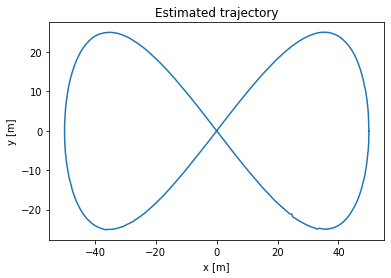

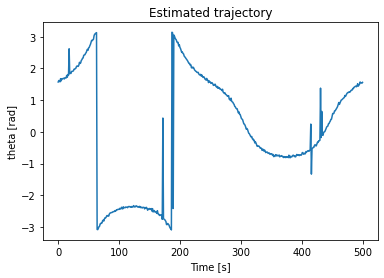

In [66]:
e_fig = plt.figure()
ax = e_fig.add_subplot(111)
ax.plot(x_est[:, 0], x_est[:, 1])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Estimated trajectory')
plt.show()

e_fig = plt.figure()
ax = e_fig.add_subplot(111)
ax.plot(t[:], x_est[:, 2])
ax.set_xlabel('Time [s]')
ax.set_ylabel('theta [rad]')
ax.set_title('Estimated trajectory')
plt.show()

Are you satisfied wth your results? The resulting trajectory should closely resemble the ground truth, with minor "jumps" in the orientation estimate due to angle wrapping. If this is the case, run the code below to produce your solution file.

In [67]:
with open('submission.pkl', 'wb') as f:
    pickle.dump(x_est, f, pickle.HIGHEST_PROTOCOL)